In [1]:
from openbb_terminal.sdk import openbb
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf

import statsmodels.api as sm

from pykalman import KalmanFilter

from sklearn.decomposition import PCA
from statsmodels import regression
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

def omega_ratio(returns, required_return=0.0):
    """Determines the Omega ratio of a strategy.

    Parameters
    ----------
    returns: pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    required_return: float, optional
        Minimum acceptance return of the investor. Threshold over which to
        consider positive vs negative returns. It will be converted to a 
        value appropritae for the period of the returns. E.g An annual minimum
        acceptable return of 100 will translate to a minimum acceptable
        reutnr of 0.018

    Returns
    -------
    omega_ratio : float

    Note
    ----
    See https://en.wikipedia.org/wiki/Omega_ratio for more details.
    """

    return_threshold = (1 + required_return) ** (1/252) - 1

    returns_less_thresh = returns - return_threshold

    numer = sum(returns_less_thresh[returns_less_thresh > 0.0])
    denom = -1.0 * sum(returns_less_thresh[returns_less_thresh < 0.0])

    if denom > 0.0:
        return numer / denom
    
    return np.nan

In [20]:
df = openbb.economy.unemp(2010)
df = df.set_index("date")[:"2019-12-31"].sort_index()

In [21]:
df

,unemp
date,
2010-01-01,9.8
2010-02-01,9.8
2010-03-01,9.9
2010-04-01,9.9
2010-05-01,9.6
...,...
2019-08-01,3.7
2019-09-01,3.5
2019-10-01,3.6


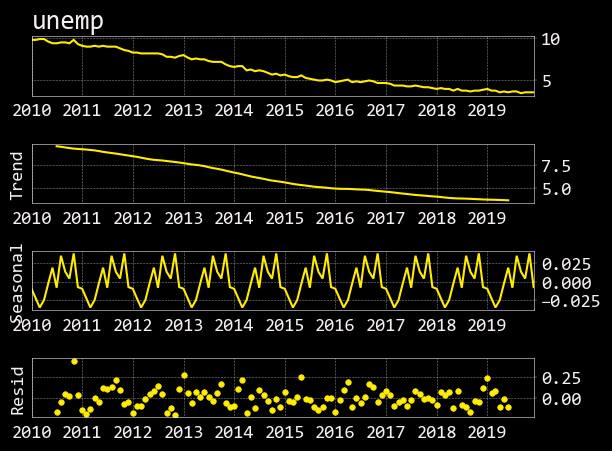

In [22]:
decomposition_results = seasonal_decompose(df["unemp"], model="additive").plot()

Text(0.5, 0.98, 'STL Decomposition')

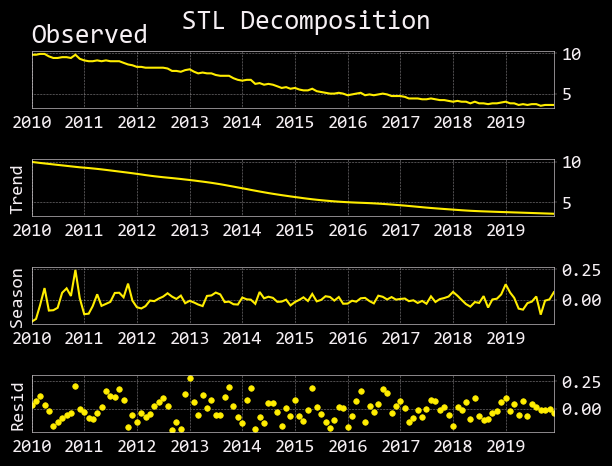

In [23]:
stl_decomposition = STL(df[["unemp"]]).fit()
stl_decomposition.plot().suptitle("STL Decomposition")

Loading Daily data for ^GSPC with starting period 2000-01-03.

<AxesSubplot: title={'left': 'S&P 500'}, xlabel='date'>

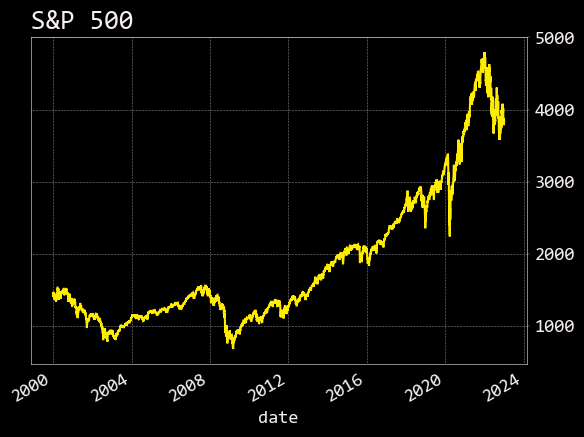

In [25]:
df = openbb.stocks.load(
    "^GSPC", 
    start_date="2000-01-01",
    end_date="2022-12-31"
)["Adj Close"]
df.plot(title="S&P 500")


In [27]:
for lag in [20,100,250,500,1000]:
    hurst_exp = get_hurst_exponent(df.values, lag)
    print(f"{lag} lags: {hurst_exp:.4f}")

20 lags: 0.4751
100 lags: 0.4329
250 lags: 0.4783
500 lags: 0.4893
1000 lags: 0.4638


In [28]:
shorter_series = df.loc["2005":"2007"].values
for lag in [20,100,250,500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"{lag} lags: {hurst_exp:.4f}")   

20 lags: 0.3989
100 lags: 0.3215
250 lags: 0.2507
500 lags: 0.1258


In [39]:
data = openbb.stocks.load("LMT", start_date="2013-01-01", end_date="2015-01-01")
prices = data["Adj Close"]

Loading Daily data for LMT with starting period 2013-01-02.

In [40]:
kf = KalmanFilter(
    transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance = 1,
    transition_covariance=0.01
)

state_means, _ = kf.filter(prices.values)
state_means = pd.Series(state_means.flatten(), index=prices.index)

Text(0, 0.5, 'Price')

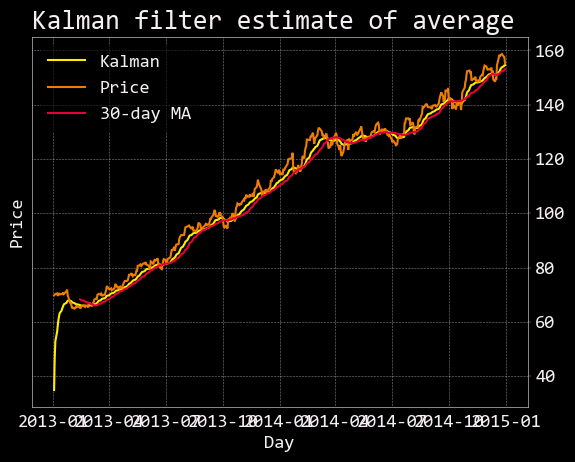

In [41]:
kf = KalmanFilter(
    transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance = 1,
    transition_covariance=0.01
)

state_means, _ = kf.filter(prices.values)
state_means = pd.Series(state_means.flatten(), index=prices.index)

mean30 = prices.rolling(window=30).mean()

plt.plot(state_means)
plt.plot(prices)
plt.plot(mean30)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman', 'Price', '30-day MA'])
plt.xlabel('Day')
plt.ylabel('Price')


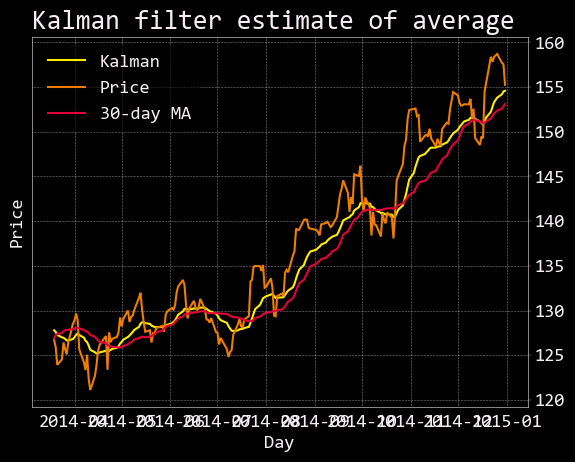

In [42]:
# Zoom in on the last 200 days to get a closer look.

plt.plot(state_means[-200:])
plt.plot(prices[-200:])
plt.plot(mean30[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman', 'Price', '30-day MA'])
plt.xlabel('Day')
plt.ylabel('Price');


In [44]:
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start = '2000-01-01'
)[0][1:]

SMB = factors.SMB
HML = factors.HML

In [45]:
data = yf.download(
    ['SPY', 'MSFT', 'AAPL', 'INTC'],
    start="2000-01-01",
    interval="1mo"
)['Adj Close']

monthly_returns = data.pct_change().to_period("M")

[*********************100%***********************]  4 of 4 completed


/tmp/ipykernel_395597/1150623409.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_returns = data.pct_change().to_period("M")


In [46]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = R - bench

In [49]:
df = pd.DataFrame({
    'R': active,
    'F1': SMB,
    'F2': HML,
}).dropna()

b1, b2 = regression.linear_model.OLS(
    df.R,
    df[['F1', 'F2']]
).fit().params

print(f'Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}')

Sensitivities of active returns to factors:
SMB: 0.002370844143171699
HML: -0.0055783156912085855


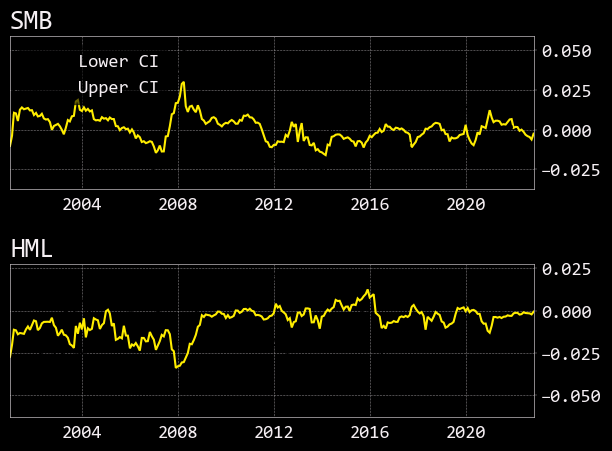

In [50]:
exog_vars = ["SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(df.R, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars)

In [51]:
F1 = df.F1
F2 = df.F2

cov = np.cov(F1, F2)
ar_squared = (active.std())**2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[0,0])) / ar_squared
print(f"SMB risk contribution: {mcar1}")
print(f"SMB risk contribution: {mcar2}")
print(f"Unexplained risk contribution: {1-(mcar1+mcar2)}")

SMB risk contribution: 0.0263733357265642
SMB risk contribution: 0.10597323026533251
Unexplained risk contribution: 0.8676534340081032


In [58]:
symbols = [
    'IBM',
    'MSFT',
    'META',
    'INTC',
    'NEM',
    'AU',
    'AEM',
    'GFI'
]
data = yf.download(symbols, start="2020-01-01", end="2023-12-31")
portfolio_returns = data['Adj Close'].pct_change().dropna()

[*********************100%***********************]  8 of 8 completed


In [59]:
pca = PCA(n_components=3)
pca.fit(portfolio_returns)

pct = pca.explained_variance_ratio_
pca_components = pca.components_

(0.0, 100.0)

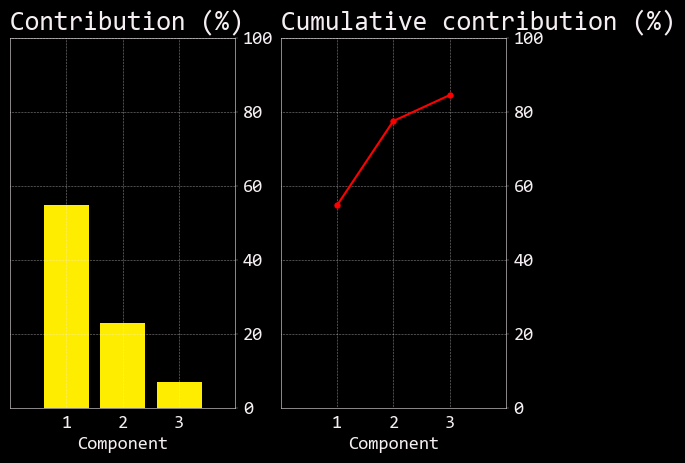

In [60]:
cum_pct = np.cumsum(pct)
x = np.arange(1,len(pct)+1,1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title('Contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Cumulative contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

In [61]:
X = np.asarray(portfolio_returns)

factor_returns = X.dot(pca_components.T)

factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"], 
    index=portfolio_returns.index,
    data=factor_returns
)

factor_returns.head()


,f1,f2,f3
Date,,,
2020-01-03 00:00:00-05:00,-0.012018,0.015615,-0.007366
2020-01-06 00:00:00-05:00,0.009653,-0.010051,-0.013527
2020-01-07 00:00:00-05:00,-0.007072,0.009738,-0.008984
2020-01-08 00:00:00-05:00,-0.074063,-0.032544,-0.002223
2020-01-09 00:00:00-05:00,-0.011894,-0.023992,-0.001319


<AxesSubplot: >

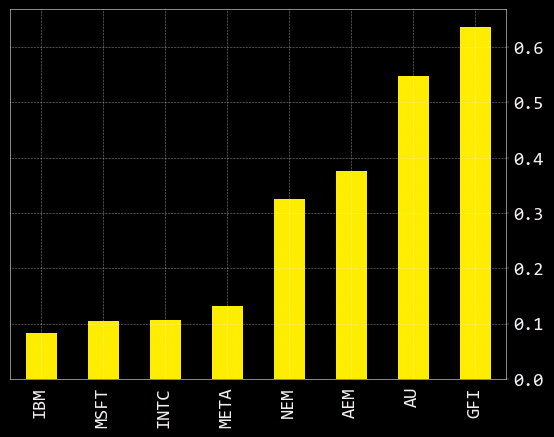

In [63]:
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"], 
    columns=portfolio_returns.columns,
    data = pca_components
).T
factor_exposures.f1.sort_values().plot.bar()

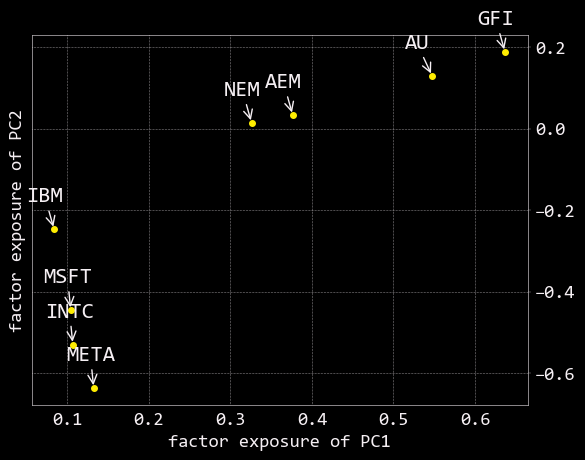

In [66]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('factor exposure of PC1')
plt.ylabel('factor exposure of PC2')

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), 
        xytext=(-20, 20),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )